In [1]:
import numpy as np
import traci
import matplotlib.pyplot as plt
import pickle

from helper_functions import get_nearest_vehicle_distance, update_live_plot

# Parameters

In [2]:
# Simulation parameters
SUMO_BINARY = "sumo"  # or "sumo-gui"
SUMO_CONFIG = "../config/my_simulation.sumocfg"
SIMULATION_STEPS = 10000

# Parameters
ACTION_SIZE = 2

# State discretezation & normalization parameters
STATE_BINS = [10, 10, 10, 2, 2, 10]
feature_min = [0, 0, 0, 0, 0, 10]  # Min values for each state feature
feature_max = [10, 15, 18, 1, 1, 150]  # Max values for each state feature

# Loading the model

In [3]:
# Load the model
with open("saved_models/ql_model.pkl", "rb") as f:
    ql_policy = pickle.load(f)

print(ql_policy.shape)

(10, 10, 10, 2, 2, 10, 2)


# MDP

### State Space

In [4]:
# Helper functions
def discretize_state(state):
    """Discretize the continuous state into discrete bins."""
    state_bins = []
    for i, feature in enumerate(state):
        bin_index = int((feature - feature_min[i]) / (feature_max[i] - feature_min[i]) * (STATE_BINS[i] - 1))
        state_bins.append(np.clip(bin_index, 0, STATE_BINS[i] - 1))

    # print(tuple(state_bins))
    return tuple(state_bins)


In [5]:
def get_state():
    """Retrieve the current state from SUMO"""

    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    
    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")


    state = [
        highway_density,
        highway_speed,
        ramp_speed,
        highway_halts,
        ramp_halts,
        nearest_distance_highway
    ]
    
    return state


### Reward Function

In [6]:
def calculate_reward(state):
    """Calculate reward based on the current state"""

    highway_speed = state[1]
    ramp_speed = state[2]
    highway_halts = state[3]
    ramp_halts = state[4]

    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()       # Emergency stopping cars
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()              # Collisions (accidents)

    reward = - (highway_halts + ramp_halts + nbr_stopping_vehicles) + (highway_speed + ramp_speed) * 0.1 - nbr_colliding_vehicles * 10
    
    return reward

### Action Space

In [7]:
def take_action(action):
    """Apply the selected action in SUMO"""
    traci.trafficlight.setPhase("J11", action)

# Inference

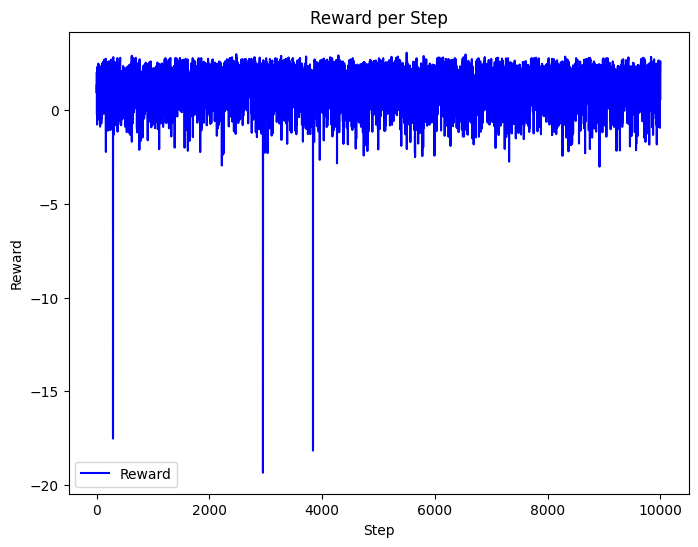

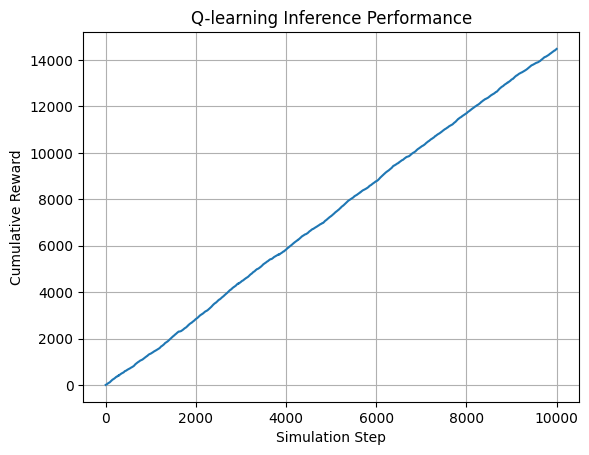

In [8]:
rewards_per_step = []
UPDATE_PLOT_FREQ = 10

traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])

# Initialize the runtime plot
plt.ion()
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Reward per Step")
ax.set_xlabel("Step")
ax.set_ylabel("Reward")
line, = ax.plot([], [], label="Reward", color='blue')
ax.legend()

try:
    for step in range(SIMULATION_STEPS):
        # Get current state
        state = discretize_state(get_state())

        # Choose action from policy
        action = np.argmax(ql_policy[state])

        # Apply action and step simulation
        take_action(action)
        traci.simulationStep()

        # Optionally, calculate reward (not used for inference)
        reward = calculate_reward(get_state())
        rewards_per_step.append(reward)

        # Monitor progress
        if step % 1000 == 0:
            print(f"Simulation step {step}/{SIMULATION_STEPS}")

        # Update the plot
        if step % UPDATE_PLOT_FREQ == 0 or step == SIMULATION_STEPS - 1:
            update_live_plot(fig, ax, line, rewards_per_step)

finally:
    traci.close()

# Plot cumulative rewards
plt.plot(range(1, len(rewards_per_step) + 1), np.cumsum(rewards_per_step))
plt.xlabel('Simulation Step')
plt.ylabel('Cumulative Reward')
plt.title('Q-learning Inference Performance')
plt.grid(True)
plt.show()